So you have a catalog, huh? And you also have some images, huh? Maybe you want to examine them!

TODO:
    - [ ] explain what each parameter means HERE

In [1]:
%matplotlib inline
from scipy.ndimage import imread
import pandas as pd
from ast import literal_eval

from IPython.html.widgets import interact
import mpld3
mpld3.enable_notebook()

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [138]:
field_directory = '/Users/cpd/Desktop/test/fields/'
cluster_directory = '/Users/cpd/Desktop/test/clusters/'
augmented_directory = '/Users/cpd/Desktop/test/augmented/'
catalog_path = cluster_directory + 'catalog.csv'
augmented_catalog_path = augmented_directory + 'augmented_catalog.csv'
knownlens_path = '/Users/cpd/Projects/strongcnn/catalog/knownlens.csv'
collection_path = '/Users/cpd/Google Drive/cs231n/annotated_catalog.csv'

In [139]:
# run create catalog code. This can take a while.
from subprocess import call
command = ['python', './create_catalogs.py',
           '--collection', collection_path,
           '--knownlens', knownlens_path,
           '--clusters', cluster_directory,
           '--fields', field_directory,
           '--augment', augmented_directory,
           '--do_a_few', '100',
           ]
call(command)

0

In [141]:
cluster_catalog = pd.read_csv(catalog_path)
annotated_catalog = pd.read_csv(collection_path)
augmented_catalog = pd.read_csv(augmented_catalog_path)

In [142]:
catalog = cluster_catalog

blurb describing examine catalog function

In [143]:
def examine_catalog(catalog):
    def examine_cat(groupby_str):
        groupby_list = eval(groupby_str)
        print(catalog.groupby(groupby_list).apply(len))
        
    interact(examine_cat,
             groupby_str="['stage', 'flavor', 'cluster_type']")
examine_catalog(catalog)

stage  flavor           cluster_type             
1      dud              dud                           8
       lensed galaxy    dud                           6
                        simulated lensed galaxy      17
       lensed quasar    dud                           5
                        simulated lensed quasar      13
       lensing cluster  dud                           2
                        simulated lensing cluster    19
2      dud              dud                           2
       lensed galaxy    dud                           1
                        simulated lensed galaxy       1
       test             known lens                    2
                        unknown                      18
dtype: int64


If you don't have the annotated catalog, then you don't need to provide it to examine individual images. Of course, then the 'show_field' option will throw an error if marked True.

ZooID                                  ASW0005e3i
cluster_id                                     93
stage                                           1
flavor                            lensing cluster
cluster_type            simulated lensing cluster
status                                   detected
num_markers                                   136
tot_markers                                   138
cluster_marked_looks                           65
total_marked_looks                             65
total_looks                                    66
dispersion                               15.58047
mean_probability                                1
x                                        264.6848
y                                        391.7964
Name: 93, dtype: object

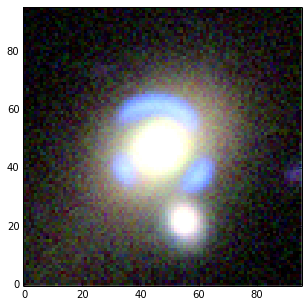

In [146]:
from create_catalogs import outlier_clusters_dbscan
from IPython.display import display

def examine_cutouts(catalog, cluster_directory, annotated_catalog=None, field_directory=None):
    # some generic things you can configure:
    # what columns we want to plot

    if 'augment_type' in catalog.columns:
        columns = ['ZooID', 'cluster_id', 'stamp_id', 'stage', 'flavor', 'cluster_type', 'status',
                   'num_markers', 'tot_markers', 'cluster_marked_looks', 'total_marked_looks', 'total_looks', 
                   'dispersion', 'mean_probability', 'x', 'y', 'augment_type']
        augmented = True
    else:
        columns = ['ZooID', 'cluster_id', 'stage', 'flavor', 'cluster_type', 'status',
                   'num_markers', 'tot_markers', 'cluster_marked_looks', 'total_marked_looks', 'total_looks', 
                   'dispersion', 'mean_probability', 'x', 'y']
        augmented = False        
    # by default the annotated image colors by group.
    # we could color by user instead
    color_by_user=False
    # training images have an alpha layer. this is useful
    # for debugging whether or not a training image was
    # properly classified
    plot_alpha=False
    # sometimes it's really hard to see the tooltips since
    # they are black and I have no idea how to change the color
    invert_color=False
    # for when you just want to see the field
    plot_points=True
    def examine_entry(i, show_field=False):
        entry = catalog.iloc[i]
        ZooID = entry['ZooID']
        entry = catalog.iloc[i]
        display(entry[columns])

        if augmented:
            cluster_path = augmented_directory + entry['stamp_name']
        else:
            cluster_path = cluster_directory + entry['cluster_name']
        
        if show_field:
            fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
            cluster = imread(cluster_path)
            axs[0].imshow(cluster)
            cat = annotated_catalog.set_index(['ZooID'])

            entry = cat.loc[ZooID]


            if plot_points:
                x_unflat = literal_eval(entry['At_X'])
                y_unflat = literal_eval(entry['At_Y'])
                # flatten out x and y. also cut out empty entries
                x = np.array([xi for xj in x_unflat for xi in xj])
                y = np.array([yi for yj in y_unflat for yi in yj])

                users = np.array([xj for xj in xrange(len(x_unflat)) for xi in x_unflat[xj]])

                cluster_centers, cluster_labels, labels = outlier_clusters_dbscan(x, y)
                if color_by_user:
                    c = users
                else:
                    c = labels
                points = axs[1].scatter(x, y, c=c, s=50, alpha=0.8, cmap=plt.cm.Accent)
                tooltiplabels = ['({0}, {1})'.format(labels[i], users[i]) for i in xrange(len(labels))]
                tooltip = mpld3.plugins.PointLabelTooltip(points, tooltiplabels)
                mpld3.plugins.connect(fig, tooltip)

            field = imread(field_directory + ZooID + '.png')#entry['ZooID'] + '.png')
            # invert field because the tooltips are in black amazingly...
            if plot_alpha:
                if np.shape(field)[-1] == 4:
                    field = field[:, :, 3]
            if invert_color:
                field = field[:,:,::-1]
            IM = axs[1].imshow(field)
            mpld3.plugins.connect(fig, mpld3.plugins.MousePosition(fontsize=14))
        else:
            fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
            cluster = imread(cluster_path)
            axs.imshow(cluster)
    
    interact(examine_entry,
             i=(0, len(catalog)-1),
             show_field=False)
    
examine_cutouts(catalog, cluster_directory, annotated_catalog, field_directory)